<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Библиотеки-и-данные" data-toc-modified-id="Библиотеки-и-данные-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Библиотеки и данные</a></span></li><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Предобработка данных</a></span></li><li><span><a href="#Обучение-алгоритма-и-построение-матрицы-ошибок" data-toc-modified-id="Обучение-алгоритма-и-построение-матрицы-ошибок-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение алгоритма и построение матрицы ошибок</a></span><ul class="toc-item"><li><span><a href="#Precision,-recall-и-F-мера" data-toc-modified-id="Precision,-recall-и-F-мера-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Precision, recall и F-мера</a></span></li><li><span><a href="#AUC-ROC-и-AUC-PR" data-toc-modified-id="AUC-ROC-и-AUC-PR-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>AUC-ROC и AUC-PR</a></span><ul class="toc-item"><li><span><a href="#Код-отрисовки-ROC-кривой" data-toc-modified-id="Код-отрисовки-ROC-кривой-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>Код отрисовки ROC-кривой</a></span></li></ul></li><li><span><a href="#Logistic-Loss" data-toc-modified-id="Logistic-Loss-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Logistic Loss</a></span></li></ul></li></ul></div>

[Ссылка на источник](https://habr.com/ru/company/ods/blog/328372/)

[Ссылка на dataset](https://www.kaggle.com/mnassrib/telecom-churn-datasets)

# Библиотеки и данные

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rc, plot
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import precision_recall_curve, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve
import numpy as np
import itertools
from itertools import product

df = pd.read_csv('data/churn-bigml-80.csv')

In [17]:
df.head(5)

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


# Предобработка данных

Сделаем маппинг бинарных колонок и закодируем dummy-кодированием штат (для простоты, лучше не делать так для деревянных моделей)

In [18]:
d = {'Yes' : 1, 'No' : 0}

df['International plan'] = df['International plan'].map(d)
df['Voice mail plan'] = df['Voice mail plan'].map(d)
df['Churn'] = df['Churn'].astype('int64')

le = LabelEncoder()
df['State'] = le.fit_transform(df['State'])

ohe = OneHotEncoder(sparse=False)

encoded_state = ohe.fit_transform(df['State'].values.reshape(-1, 1))
tmp = pd.DataFrame(encoded_state,  
                   columns=['state ' + str(i) for i in range(encoded_state.shape[1])])
df = pd.concat([df, tmp], axis=1)

# Обучение алгоритма и построение матрицы ошибок

C:\Users\vorob\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Confusion matrix, without normalization
[[737  15]
 [113  15]]


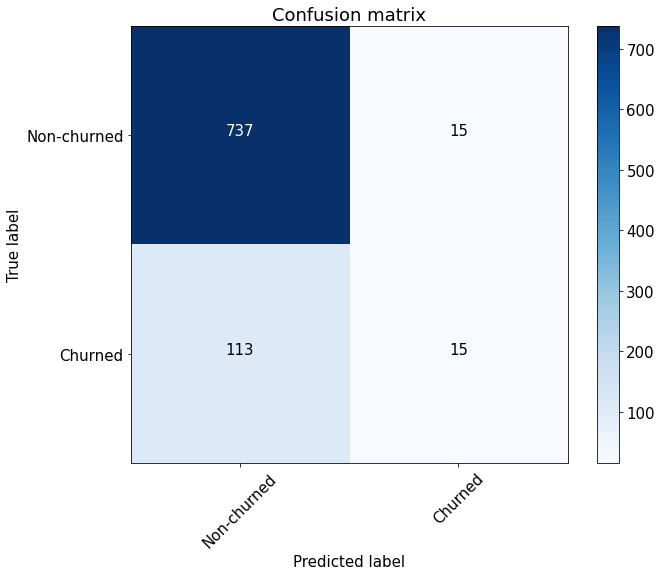

In [21]:
X = df.drop('Churn', axis=1)
y = df['Churn']

# Делим выборку на train и test, все метрики будем оценивать на тестовом датасете

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,  test_size=0.33, random_state=42)

# Обучаем ставшую родной логистическую регрессию

lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)

# Воспользуемся функцией построения матрицы ошибок из документации sklearn

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, lr.predict(X_test))
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-churned', 'Churned'],
                      title='Confusion matrix');
# plt.savefig("conf_matrix.png")
plt.show();

## Precision, recall и F-мера

In [23]:
report = classification_report(y_test, lr.predict(X_test), target_names=['Non-churned', 'Churned'])
print(report)

              precision    recall  f1-score   support

 Non-churned       0.87      0.98      0.92       752
     Churned       0.50      0.12      0.19       128

    accuracy                           0.85       880
   macro avg       0.68      0.55      0.55       880
weighted avg       0.81      0.85      0.81       880



## AUC-ROC и AUC-PR

### Код отрисовки ROC-кривой

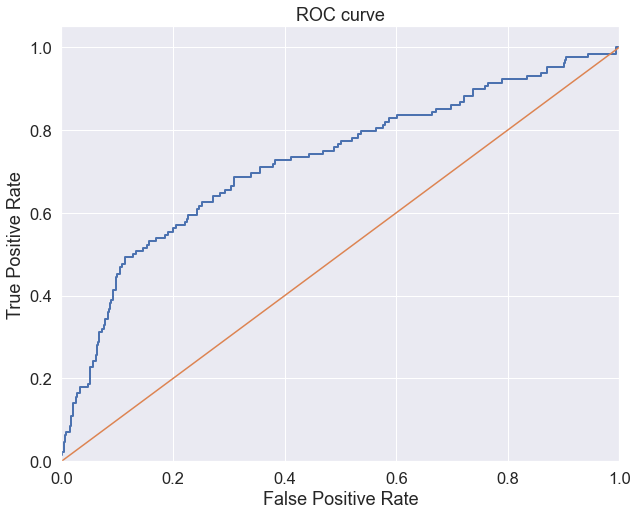

In [26]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))
fpr, tpr, thresholds = roc_curve(y_test, lr.predict_proba(X_test)[:,1], pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.show()

## Logistic Loss

In [28]:
def logloss_crutch(y_true, y_pred, eps=1e-15):

    return - (y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

print('Logloss при неуверенной классификации %f' % logloss_crutch(1, 0.5))

print('Logloss при уверенной классификации и верном ответе %f' % logloss_crutch(1, 0.9))

print('Logloss при уверенной классификации и НЕверном ответе %f' % logloss_crutch(1, 0.1))


Logloss при неуверенной классификации 0.693147
Logloss при уверенной классификации и верном ответе 0.105361
Logloss при уверенной классификации и НЕверном ответе 2.302585
